# Feed-Forward Neural Netowrk
A simple implementation for a classification problem of predicting avocado ripeness

## Problem description

**Goal**: Predict avocado ripeness

## Setup

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout

set_config(transform_output='pandas')

## Exploratory Analysis

In [64]:
raw = pd.read_csv("data/avocado_ripeness_dataset.csv")
raw

,firmness,hue,saturation,brightness,color_category,sound_db,weight_g,size_cm3,ripeness
0,14.5,19,40,26,black,34,175,261,ripe
1,71.7,53,69,75,green,69,206,185,pre-conditioned
2,88.5,60,94,46,dark green,79,220,143,hard
3,93.8,105,87,41,dark green,75,299,140,hard
4,42.5,303,58,32,purple,63,200,227,breaking
...,...,...,...,...,...,...,...,...,...
245,94.1,83,80,58,dark green,72,254,134,hard
246,21.6,17,36,19,black,47,182,240,firm-ripe
247,14.0,4,40,17,black,37,188,274,ripe
248,61.5,63,87,75,green,65,261,162,pre-conditioned


In [65]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   firmness        250 non-null    float64
 1   hue             250 non-null    int64  
 2   saturation      250 non-null    int64  
 3   brightness      250 non-null    int64  
 4   color_category  250 non-null    object 
 5   sound_db        250 non-null    int64  
 6   weight_g        250 non-null    int64  
 7   size_cm3        250 non-null    int64  
 8   ripeness        250 non-null    object 
dtypes: float64(1), int64(6), object(2)
memory usage: 17.7+ KB


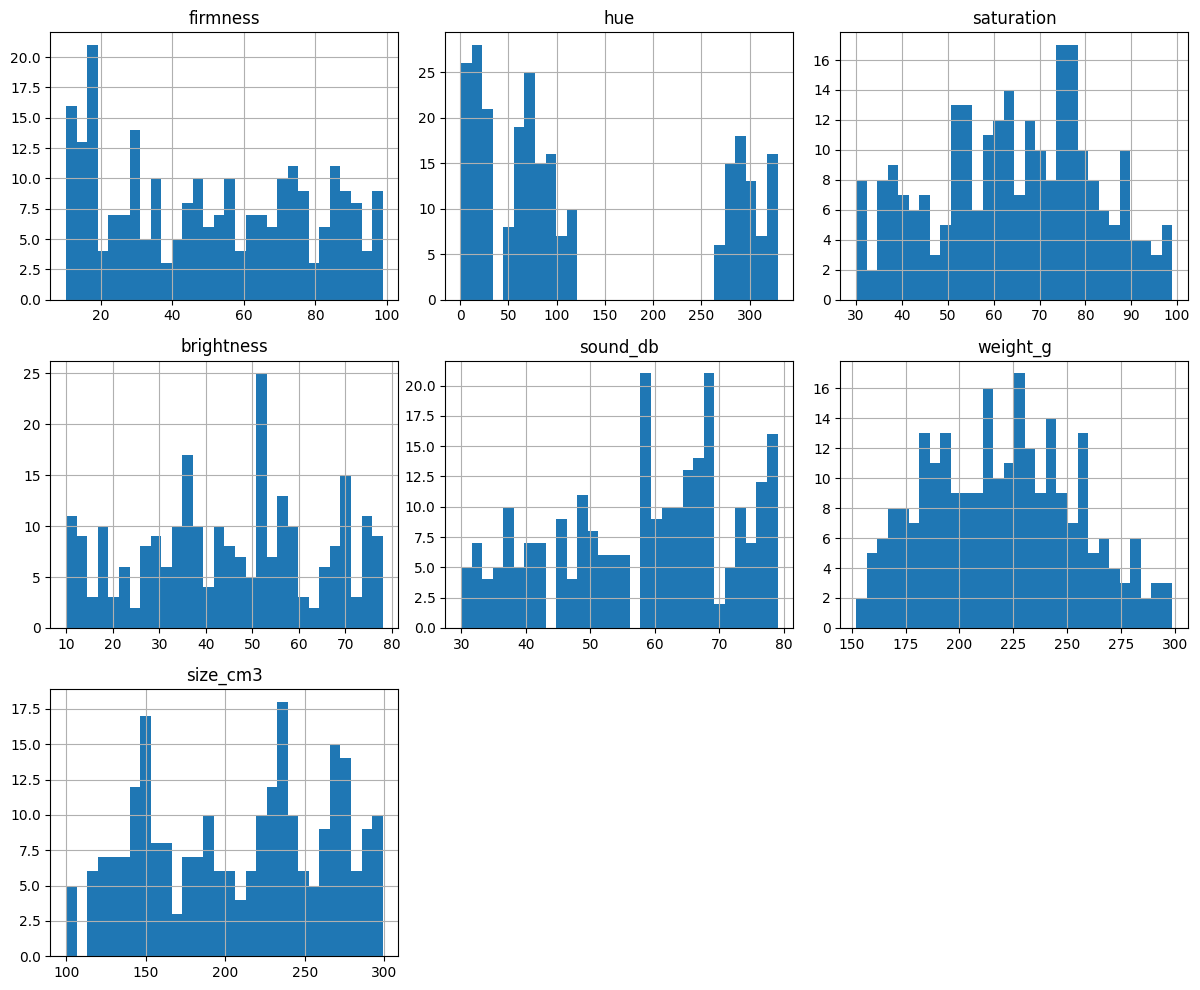

In [66]:
# this diagrams show if the data is gaussian (bell shape) or not
# this is useful to determine the best scaler: StandardScaler, MinMaxScaler or RobustScaler.
# by default, StandardScaler should be quite good, but is best with gaussian data
# if the data is not Gaussian, MinMax can be better and RobustScaler should be used in case of big outliers

raw.hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.show()

## Pre-Processing

In [67]:
# use OneHotEncoder to transform text values into numerical values
onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Encode the target variable (ripeness)
ripeness_mapping = {
    "hard": 0,
    "pre-conditioned": 1,
    "breaking": 2,
    "firm-ripe": 3,
    "ripe": 4
}

# convert categorical features
transformer = ColumnTransformer(
    transformers=[
        ('onehot', onehot, ['color_category'])
    ],
    remainder='passthrough', # all other columns remain untouched
    verbose_feature_names_out=False # keep original column names and not add 'remainder' prefix
)

# perform scaling
scaler = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['firmness','hue', 'saturation', 'brightness', 'sound_db', 'weight_g', 'size_cm3'])
    ],
    remainder='passthrough', # all other columns remain untouched
    verbose_feature_names_out=False # keep original column names and not add 'remainder' prefix
)

# run a pipeline with all transformers
pipeline = Pipeline([
    ('transform', transformer),
    ('scaler', scaler)
])

pipeline.set_output(transform="pandas")

X_transformed = pipeline.fit_transform(raw.drop('ripeness', axis=1))

# define X and y
X = X_transformed
y = raw["ripeness"].map(ripeness_mapping)
y

0      4
1      1
2      0
3      0
4      2
      ..
245    0
246    3
247    4
248    1
249    4
Name: ripeness, Length: 250, dtype: int64

## Prepare train and test data

In [68]:
# split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, shuffle=True)

X_train_rows = set(map(tuple, X_train))
X_test_rows = set(map(tuple, X_test))

# Train Model

In [69]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(11,)),   # first hidden layer with activation relu
    Dropout(rate = 0.2),             # prevents overfitting by deactivating some neurons
    Dense(32, activation='relu'),   # second hidden layer
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/home/carlos/projects/ai/portfolio/ffn-classification-avocado/python-env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,461 (13.52 KB)

 Trainable params: 3,461 (13.52 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# do the training
trained_model = model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_test, y_test))

# prediction will return probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities (class with higher probability)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(accuracy))


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0979 - loss: 1.6410 - val_accuracy: 0.5200 - val_loss: 1.4418
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3597 - loss: 1.4499 - val_accuracy: 0.6600 - val_loss: 1.3218
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5037 - loss: 1.3288 - val_accuracy: 0.6600 - val_loss: 1.1738
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5195 - loss: 1.1758 - val_accuracy: 0.7000 - val_loss: 1.0087
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5237 - loss: 1.0876 - val_accuracy: 0.7800 - val_loss: 0.8438
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6256 - loss: 0.9638 - val_accuracy: 0.8800 - val_loss: 0.6999
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7308 - loss: 0.7812 - val_accuracy: 0.9000 - val_loss: 0.5843
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7528 - loss: 0.7079 - val_accuracy: 0.9200 - val_loss

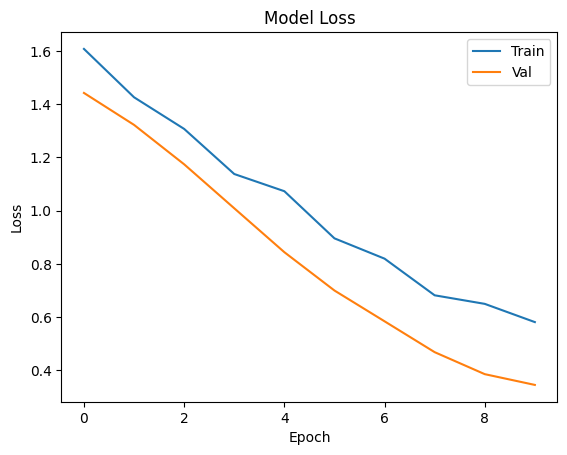

In [71]:
# visualize model loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

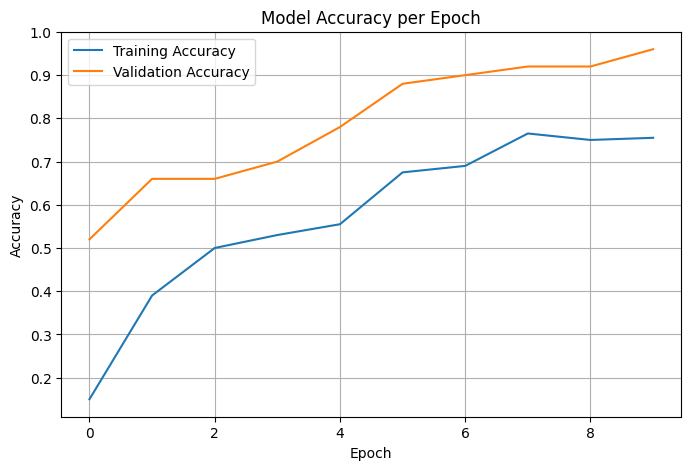

In [72]:
# Plot accuracy per epoch
plt.figure(figsize=(8, 5))
plt.plot(trained_model.history['accuracy'], label='Training Accuracy')
plt.plot(trained_model.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()